In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import gym

from torch.utils.tensorboard import SummaryWriter

In [2]:
class PolicyNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, observation):
        return self.network(observation)

Action space: Discrete(3)
Observation space: Box(6,)


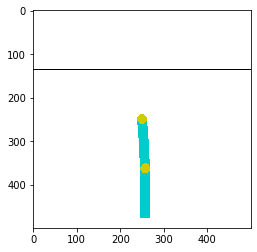

In [3]:
env = gym.make('Acrobot-v1') # make lunar-lander environment

print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

env.reset()
plt.imshow(env.render("rgb_array"))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
policy = PolicyNN(env.observation_space.shape[0], env.action_space.n).to(device)

In [6]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.99 # for calculating cumulative rewards
print_rate = 50 # rate that the output will be printed


optimizer = torch.optim.Adam(policy.parameters(), lr=learning_rate) 

In [7]:
# writer for tensorboard
writer = SummaryWriter()
# to see the board run on terminal the following command:
# tensorboard --logdir=runs

In [8]:
# this function receives a list of rewards and returns a list of the calculated cumulative rewards
# of the same size and calculated by the discount factor (gamma)
def get_cumulative_rewards(rewards, gamma=0.99):
    cumulative_rw = []
    for i in reversed(range(len(rewards))):
        rw_sum = 0
        pw = 0 # power to be applied on gamma
        for j in range(i, len(rewards)):
            rw_sum += (gamma**pw)*rewards[j] 
            pw += 1
        cumulative_rw.append(rw_sum)
        
    cumulative_rw.reverse() # reverse the list
    return cumulative_rw

### REINFORCE pseudocode (from Sutton's book, pg. 328)

Loop forever (for each episode):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Generate an episode $S_0, A_0, R_1, ..., S_{T-1}, A_{T-1}, R_T$, following $\pi(\cdot|\cdot, theta)$ 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Loop for each step of the episode t=0, 1, ..., T-1

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$G  \leftarrow \sum\nolimits_{k=t+1}^{T}  \gamma^{k-t-1}R_k $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\theta   \leftarrow  \theta +  \alpha  \gamma^t G \nabla log  \pi (A_t|S_t,  \theta )$


Basically it says:
1. Generate an entire episode following the current policy $\pi$ storing the log of each action taken and all the rewards received.
2. For each step of the episode calculate: the discounted cumulative rewards using $\gamma$ for each action.
3. Compute the policy gradient and update the parameters of the policy.  

*Obs:* 
1. As our objective is to do a gradient ascent (to increase the score function) we add to $\theta$. 
2. In the code below the rewards are also subtracted by the baseline, which is calculated according to the [Karpathy blog post](https://karpathy.github.io/2016/05/31/rl/): "e.g. subtract mean, divide by standard deviation" 


In [9]:
def train(env, gamma, n_episodes=30):
    
    rewards_history = []
    policy_history = []
    
    for episode in range(1, n_episodes+1):
        state = env.reset()
        done = False
        rewards_episode = []
        actions_episode = []
        states_episode = []
        
        # dont't calculate the gradients as you just need to sample the probability of actions
        with torch.no_grad():
            while not done:
                state = torch.tensor(state, dtype=torch.float32, device=device)
                
                action_probs = policy(state)
                # sample the distribution of action_probs
                # https://pytorch.org/docs/stable/distributions.html?highlight=distributions#module-torch.distributions
                action = torch.distributions.Categorical(action_probs).sample()
                action = int(action) # convert tensor to int

                next_state, reward, done, _ = env.step(action)

                rewards_episode.append(reward)
                actions_episode.append(action)# store log of action probabilities
                
                states_episode.append(state.cpu().numpy())

                state = next_state

        rewards_history.append(np.sum(rewards_episode))
        
        # lambda function to avoid numpy error when calculating the mean of a list
        mean_hist = lambda x, lim: np.mean(x) if len(x) > lim else np.mean(x[-lim:])
    
        if episode % print_rate == 0:
            print("Episode {} \t rewards(mean):{:.4f}".format(episode, mean_hist(rewards_history, print_rate))) 
        
        writer.add_scalar('Reward-episode', rewards_history[-1], episode)
        writer.add_scalar('Reward-mean100', mean_hist(rewards_history, 100), episode)
        
        cumulative_rewards = np.array(get_cumulative_rewards(rewards_episode, gamma)) # calculate cumulative rewards
        cumulative_rewards = (cumulative_rewards - cumulative_rewards.mean()) / cumulative_rewards.std() # normalization  
       
        # convert lists to torch tensors
        batch_states = torch.tensor(states_episode, dtype=torch.float32, device=device)
        batch_rewards = torch.tensor(cumulative_rewards, dtype=torch.float32, device=device)
        
        # run states batch through the network, therefore select the actions taken and calculate the log of each
        batch_action_probs = policy(batch_states)
        batch_log_action = torch.log(batch_action_probs[range(len(actions_episode)), actions_episode])
        
        # objective is what we want to maximize (therefore the -1)
        objective = -1*(torch.sum(batch_rewards*batch_log_action))
           
        objective.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return rewards_history

In [10]:
rewards = train(env, gamma=0.99, n_episodes=3000)

Episode 50 	 rewards(mean):-301.0600
Episode 100 	 rewards(mean):-249.9900
Episode 150 	 rewards(mean):-220.5733
Episode 200 	 rewards(mean):-201.2050
Episode 250 	 rewards(mean):-189.2400
Episode 300 	 rewards(mean):-177.8800
Episode 350 	 rewards(mean):-170.4543
Episode 400 	 rewards(mean):-163.1450
Episode 450 	 rewards(mean):-156.4911
Episode 500 	 rewards(mean):-151.4800
Episode 550 	 rewards(mean):-146.7236
Episode 600 	 rewards(mean):-143.1383
Episode 650 	 rewards(mean):-140.6615
Episode 700 	 rewards(mean):-137.6986
Episode 750 	 rewards(mean):-134.8587
Episode 800 	 rewards(mean):-133.1550
Episode 850 	 rewards(mean):-131.2882
Episode 900 	 rewards(mean):-129.6389
Episode 950 	 rewards(mean):-128.1421
Episode 1000 	 rewards(mean):-126.5080
Episode 1050 	 rewards(mean):-125.4057
Episode 1100 	 rewards(mean):-124.1800
Episode 1150 	 rewards(mean):-123.1383
Episode 1200 	 rewards(mean):-121.9192
Episode 1250 	 rewards(mean):-121.1560
Episode 1300 	 rewards(mean):-120.0423
Episod

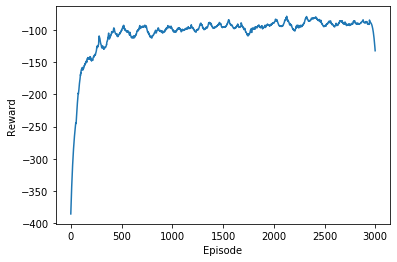

In [11]:
from scipy.signal import savgol_filter

plt.plot(savgol_filter(rewards, 99, 3))
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [13]:
# play some episodes to see how it's working 
from time import sleep

policy.eval() # set model to evaluation mode

for i in range(3):
    state = env.reset()
    done = False
    reward_sum = 0
    while not done:
        env.render()
        state = torch.tensor(state, dtype=torch.float32, device=device)
        action_probs = policy(state)

        action = int(torch.distributions.Categorical(action_probs).sample())
        
        state, reward, done, _ = env.step(action)
        reward_sum += reward
 
        sleep(0.01)
    print("Episode finished. Reward={:.4f}".format(reward_sum))

Episode finished. Reward=-88.0000
Episode finished. Reward=-82.0000
Episode finished. Reward=-121.0000
